In [5]:
import pandas as pd
from utils.quack import Quack
pd.set_option('display.max_columns', 45)

In [6]:
df = Quack.query("""
select game_id, week, season, play_type, "desc", case when field_goal_result = 'made' then 1 when field_goal_result = 'missed' then 0 end as result,
			kick_distance, kicker_player_id,
			kicker_player_name, wind, temp, roof from pbp where play_type = 'field_goal' 
			and field_goal_result <> 'blocked'
;""")
df.iloc[10].to_dict()

{'game_id': '2000_01_CHI_MIN',
 'week': 1,
 'season': 2000,
 'play_type': 'field_goal',
 'desc': '(1:16) G.Anderson 38 yard field goal is GOOD, Center-M.Palmer, Holder-M.Berger.',
 'result': 1,
 'kick_distance': 38.0,
 'kicker_player_id': '00-0000313',
 'kicker_player_name': 'G.Anderson',
 'wind': nan,
 'temp': nan,
 'roof': 'dome'}

In [9]:
df['result'].mean()

np.float64(0.8467726265884273)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)

def create_model(df, x_cols, y_col, colsample_bytree=0.5, categorical=False) -> xgb.XGBClassifier:
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBClassifier(eval_metric="mlogloss", colsample_bytree=colsample_bytree, missing=np.nan, enable_categorical=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    return model


x_cols = ['wind', 'temp', 'kick_distance', 'season']
y_col = ['result']
model = create_model(df,x_cols, y_col[0])
model

Accuracy: 0.86
Confusion Matrix:
[[  68  668]
 [  74 4337]]


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,'mlogloss'


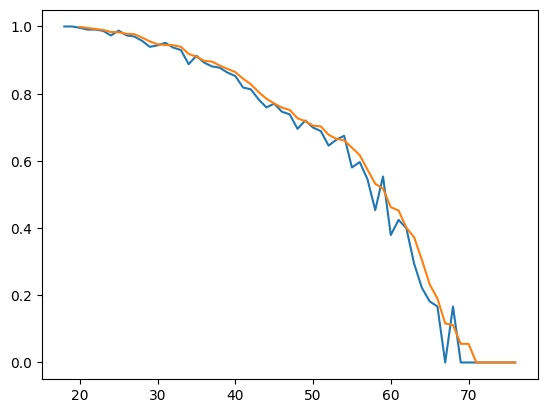

In [17]:
out = df.groupby(['kick_distance'])['result'].mean().reset_index()
out['result_avg'] = out['result'].rolling(3).mean()
import matplotlib.pyplot as plt


plt.plot(out['kick_distance'], out['result'])
plt.plot(out['kick_distance'], out['result_avg'])

In [25]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix

y_pred = model.predict(df[x_cols])
y_proba = model.predict_proba(df[x_cols])[:,1]

y_test = df[y_col]
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))
print("F1:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.8260038906878271
PR-AUC: 0.9621552816920216
F1: 0.9225169674781082
Confusion matrix:
 [[  570  3373]
 [  246 21544]]


In [28]:
df['pred'] = y_proba
df

,game_id,week,season,play_type,desc,result,kick_distance,kicker_player_id,kicker_player_name,wind,temp,roof,pred
0,2000_01_ARI_NYG,1,2000,field_goal,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",1,32.0,00-0001343,C.Blanchard,3.0,80.0,outdoors,0.909958
1,2000_01_BAL_PIT,1,2000,field_goal,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",1,23.0,00-0015784,M.Stover,8.0,74.0,outdoors,0.994617
2,2000_01_BAL_PIT,1,2000,field_goal,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",1,26.0,00-0015784,M.Stover,8.0,74.0,outdoors,0.971350
3,2000_01_BAL_PIT,1,2000,field_goal,"(15:00) M.Stover 33 yard field goal is GOOD, C...",1,33.0,00-0015784,M.Stover,8.0,74.0,outdoors,0.832834
4,2000_01_BAL_PIT,1,2000,field_goal,"(11:31) K.Brown 45 yard field goal is No Good,...",0,45.0,00-0001980,K.Brown,8.0,74.0,outdoors,0.734882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25728,2025_12_BUF_HOU,12,2025,field_goal,(4:36) 15-K.Fairbairn 24 yard field goal is GO...,1,24.0,00-0032726,K.Fairbairn,NaN,NaN,closed,0.981985
25729,2025_12_BUF_HOU,12,2025,field_goal,"(9:39) 15-M.Prater 44 yard field goal is GOOD,...",1,44.0,00-0023853,M.Prater,NaN,NaN,closed,0.801963
25730,2025_12_BUF_HOU,12,2025,field_goal,(2:00) 15-K.Fairbairn 43 yard field goal is GO...,1,43.0,00-0032726,K.Fairbairn,NaN,NaN,closed,0.838142
25731,2025_12_BUF_HOU,12,2025,field_goal,(:21) 15-K.Fairbairn 26 yard field goal is GOO...,1,26.0,00-0032726,K.Fairbairn,NaN,NaN,closed,0.969935


In [30]:
df.groupby('kick_distance')[['result', 'pred']].mean()

,result,pred
kick_distance,,
18.0,1.000000,0.998816
19.0,1.000000,0.999112
20.0,0.996040,0.999064
21.0,0.990775,0.991771
22.0,0.990840,0.990199
23.0,0.986962,0.986834
24.0,0.973228,0.977622
25.0,0.987673,0.984678
26.0,0.973684,0.973575


In [31]:
df.columns

Index(['game_id', 'week', 'season', 'play_type', 'desc', 'result',
       'kick_distance', 'kicker_player_id', 'kicker_player_name', 'wind',
       'temp', 'roof', 'pred'],
      dtype='object')

In [113]:
def calculate_kicker_ratings(df, k_fast=40, k_slow=8, initial_rating=1500):
    """
    Calculate kicker ratings on two timescales:
    - rating_fast: quickly adapts to recent form / injuries
    - rating_slow: slowly adapts, reflects underlying skill
    
    Parameters:
    -----------
    df : DataFrame with ['kicker_player_id', 'result', 'pred', 'season', 'week']
    k_fast : fast-updating k-factor
    k_slow : slow-updating k-factor
    initial_rating : starting rating for all kickers
    
    Returns:
    --------
    df with 'rating_fast', 'rating_slow', and 'rating_combined'
    """
    
    df = df.sort_values(['season', 'week']).copy()
    
    ratings_fast = {}
    ratings_slow = {}
    
    rating_fast_list = []
    rating_slow_list = []
    rating_combined_list = []
    
    for idx, row in df.iterrows():
        kicker_id = row['kicker_player_id']
        
        # Initialize ratings if new kicker
        if kicker_id not in ratings_fast:
            ratings_fast[kicker_id] = initial_rating
            ratings_slow[kicker_id] = initial_rating
        
        # Current ratings
        r_fast = ratings_fast[kicker_id]
        r_slow = ratings_slow[kicker_id]
        
        # ELO-style expected probabilities
        elo_expected_fast = 1 / (1 + 10 ** ((initial_rating - r_fast) / 400))
        elo_expected_slow = 1 / (1 + 10 ** ((initial_rating - r_slow) / 400))
        
        # Combine with situational probability
        combined_expected_fast = (elo_expected_fast + row['pred']) / 2
        combined_expected_slow = (elo_expected_slow + row['pred']) / 2
        
        actual = row['result']
        
        # Update ratings
        ratings_fast[kicker_id] = r_fast + k_fast * (actual - combined_expected_fast)
        ratings_slow[kicker_id] = r_slow + k_slow * (actual - combined_expected_slow)
        
        rating_fast_list.append(ratings_fast[kicker_id])
        rating_slow_list.append(ratings_slow[kicker_id])
        
        # Optional: combined rating for modeling/prediction
        rating_combined_list.append(0.6 * ratings_fast[kicker_id] + 0.4 * ratings_slow[kicker_id])
    
    df['rating_fast'] = rating_fast_list
    df['rating_slow'] = rating_slow_list
    df['rating'] = rating_combined_list
    df['rating_fast_change'] = df['rating_fast'] - df.groupby('kicker_player_id')['rating_fast'].shift(1).fillna(initial_rating)
    df['rating_slow_change'] = df['rating_slow'] - df.groupby('kicker_player_id')['rating_slow'].shift(1).fillna(initial_rating)
    
    return df


df2 = calculate_kicker_ratings(df, k_fast=175, initial_rating=1500)

# View current ratings
current_ratings = df2.groupby('kicker_player_name').agg({
    'rating_fast': 'last',
    'rating_slow': 'last',
    'rating': 'last',
    'kicker_player_id': 'first',
    'season': 'last'
}).sort_values('rating', ascending=False)
print(current_ratings)

                    rating_fast  rating_slow       rating kicker_player_id  \
kicker_player_name                                                           
N.Folk              2389.785935  1818.662143  2161.336418       00-0025565   
C.Boswell           2318.901061  1797.817796  2110.467755       00-0031136   
M. Vanderjagt       2346.368662  1675.143734  2077.878691       00-0016830   
B.Aubrey            2249.377283  1662.891424  2014.782939       00-0037692   
C.Dicker            2202.559772  1682.110519  1994.380071       00-0037224   
...                         ...          ...          ...              ...   
O.Pochman           1332.252310  1493.875745  1396.901684       00-0020379   
S.Castillo          1322.840454  1499.476291  1393.494789       00-0031385   
N.Freese            1250.572498  1485.247373  1344.442448       00-0031093   
K.Brindza           1198.251927  1485.633161  1313.204421       00-0031656   
M.Koenen            1191.767262  1481.422245  1307.629255       

In [114]:
df2

,game_id,week,season,play_type,desc,result,kick_distance,kicker_player_id,kicker_player_name,wind,temp,roof,pred,rating_fast,rating_slow,rating,rating_fast_change,rating_slow_change
0,2000_01_ARI_NYG,1,2000,field_goal,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",1,32.0,00-0001343,C.Blanchard,3.0,80.0,outdoors,0.909958,1551.628664,1502.360168,1531.921265,51.628664,2.360168
1,2000_01_BAL_PIT,1,2000,field_goal,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",1,23.0,00-0015784,M.Stover,8.0,74.0,outdoors,0.994617,1544.220988,1502.021531,1527.341205,44.220988,2.021531
2,2000_01_BAL_PIT,1,2000,field_goal,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",1,26.0,00-0015784,M.Stover,8.0,74.0,outdoors,0.971350,1584.939325,1504.124495,1552.613393,40.718337,2.102964
3,2000_01_BAL_PIT,1,2000,field_goal,"(15:00) M.Stover 33 yard field goal is GOOD, C...",1,33.0,00-0015784,M.Stover,8.0,74.0,outdoors,0.832834,1632.828713,1506.769419,1582.404995,47.889388,2.644924
4,2000_01_BAL_PIT,1,2000,field_goal,"(11:31) K.Brown 45 yard field goal is No Good,...",0,45.0,00-0001980,K.Brown,8.0,74.0,outdoors,0.734882,1391.947784,1495.060470,1433.192858,-108.052216,-4.939530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25728,2025_12_BUF_HOU,12,2025,field_goal,(4:36) 15-K.Fairbairn 24 yard field goal is GO...,1,24.0,00-0032726,K.Fairbairn,NaN,NaN,closed,0.981985,1903.336831,1725.779322,1832.313827,9.804195,0.932548
25729,2025_12_BUF_HOU,12,2025,field_goal,"(9:39) 15-M.Prater 44 yard field goal is GOOD,...",1,44.0,00-0023853,M.Prater,NaN,NaN,closed,0.801963,1835.077982,1767.417173,1808.013659,30.228915,1.503701
25730,2025_12_BUF_HOU,12,2025,field_goal,(2:00) 15-K.Fairbairn 43 yard field goal is GO...,1,43.0,00-0032726,K.Fairbairn,NaN,NaN,closed,0.838142,1925.316121,1727.283622,1846.103122,21.979291,1.504300
25731,2025_12_BUF_HOU,12,2025,field_goal,(:21) 15-K.Fairbairn 26 yard field goal is GOO...,1,26.0,00-0032726,K.Fairbairn,NaN,NaN,closed,0.969935,1934.908421,1728.254933,1852.247025,9.592299,0.971311


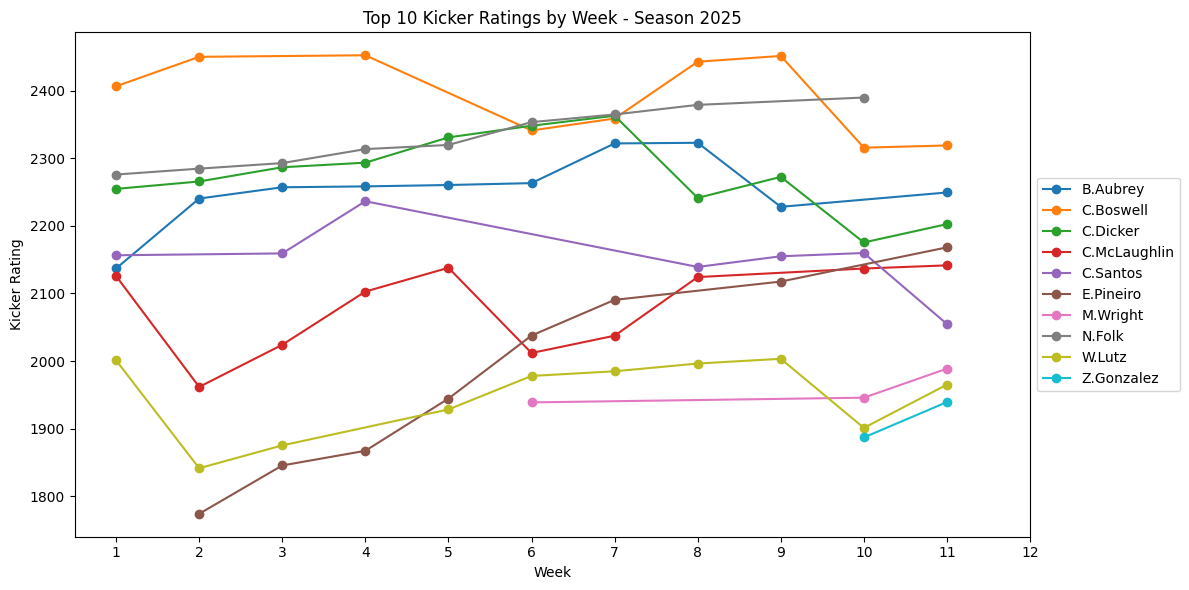

In [115]:
# Get the top 10 kickers by final rating in the season
final_ratings = (
    df_season.groupby('kicker_player_name', as_index=False)
             .agg({'rating':'last'})
)
top_kickers = final_ratings.nlargest(10, 'rating')['kicker_player_name']

# Filter weekly ratings for only top 10 kickers
weekly_ratings_top10 = weekly_ratings[weekly_ratings['kicker_player_name'].isin(top_kickers)]

# Plot
plt.figure(figsize=(12,6))
for kicker, group in weekly_ratings_top10.groupby('kicker_player_name'):
    plt.plot(group['week'], group['rating'], marker='o', label=kicker)

plt.xlabel('Week')
plt.ylabel('Kicker Rating')
plt.title(f'Top 10 Kicker Ratings by Week - Season {current_season}')
plt.xticks(range(1, df_season['week'].max()+1))
plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [128]:
# Find the index of each kicker's max rating
idx = df2.groupby('kicker_player_name')['rating'].idxmax()

# Use that to get the corresponding rating and season/week/game
max_ratings = df2.loc[idx, ['kicker_player_name', 'rating', 'season', 'week']]

# Optional: sort by rating
max_ratings = max_ratings.sort_values('rating', ascending=False).reset_index(drop=True)

max_ratings.head(20)


,kicker_player_name,rating,season,week
0,J.Tucker,2601.196053,2018,16
1,R.Gould,2263.387405,2019,1
2,M.Bryant,2262.246874,2018,13
3,J.Hanson,2237.660668,2009,5
4,A.Vinatieri,2223.877308,2016,9
5,C.Boswell,2217.350013,2025,6
6,S.Gostkowski,2177.719428,2015,11
7,J.Brown,2171.457805,2015,13
8,N.Folk,2161.336418,2025,10
9,M.Crosby,2158.035780,2021,5


In [129]:
max_ratings.loc[max_ratings.kicker_player_name=='M.Anderson']

,kicker_player_name,rating,season,week


In [78]:
def calibrate_k_value(df, k_values=range(10, 400, 20), window_size=15):
    """
    Calibrate k-factor for kicker ratings.
    
    For each k, calculate kicker ratings and test if current rating predicts
    performance over the next `window_size` kicks.
    """
    results = []
    df_sorted = df.sort_values(['season', 'week']).copy()

    def compute_future_outperformance(sub_df, window):
        """Compute rolling future overperformance for a single kicker."""
        future_result = sub_df['result'].shift(-1).rolling(window, min_periods=1).mean()
        future_pred = sub_df['pred'].shift(-1).rolling(window, min_periods=1).mean()
        return future_result - future_pred

    for k in k_values:
        df_rated = calculate_kicker_ratings(df_sorted, k_factor=k)
        
        # Calculate future outperformance per kicker
        df_rated['future_outperformance'] = (
            df_rated.groupby('kicker_player_id', group_keys=False)
                    .apply(lambda x: compute_future_outperformance(x, window_size))
        )
        
        # Remove rows without enough future data
        df_valid = df_rated[df_rated['future_outperformance'].notna()]
        
        # Correlation: does current rating predict next N kicks?
        corr = df_valid['rating'].corr(df_valid['future_outperformance']) if len(df_valid) > 0 else 0
        
        results.append({
            'k_value': k,
            'correlation': corr,
            'n_samples': len(df_valid),
            'rating_std': df_rated['rating'].std(),
        })
    
    return pd.DataFrame(results)


In [79]:
calibrate_k_value(df)

C:\Users\Sharedw\AppData\Local\Temp\ipykernel_66204\1845825569.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_future_outperformance(x, window_size))
C:\Users\Sharedw\AppData\Local\Temp\ipykernel_66204\1845825569.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_future_outperformance(x, window_size))
C:\Users\Sharedw\AppData\Local\Temp\ipykernel_6620

,k_value,correlation,n_samples,rating_std
0,10,0.212413,25719,91.023596
1,30,0.338434,25719,119.738632
2,50,0.434976,25719,132.113535
3,70,0.505324,25719,143.870043
4,90,0.555228,25719,156.153482
5,110,0.590154,25719,168.901058
6,130,0.614284,25719,181.976698
7,150,0.630631,25719,195.283404
8,170,0.641340,25719,208.757565
9,190,0.647953,25719,222.356443
